**Importar Librerias**

**CNN**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Conv2D,MaxPooling2D, Flatten, Dense,Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from scipy.stats import spearmanr
from sklearn.model_selection import KFold

**Definir Parametros**

In [3]:
# Parámetros globales
rows, cols, channels = 95,68, 1 #190, 136, 1    95,68,1
n_iteraciones = 1 #aumentar hasta (10,20,30) después de las pruebas

cargar datos

In [4]:
# Ruta del archivo de datos
data_path = '/kaggle/input/data-dias/Datos_dias.xlsx'
data = pd.read_excel(data_path)

# Selección de columnas de entrada y salida
input_features = ['Irradiancia', 'NO3', 'TEMP', 'pH', 'CO2 Gas']
output_feature = 'biomasa'

# Aplicar escaladores
#scaler = StandarScaler()
#scaler = RobustScaler()
scaler = MinMaxScaler()
data[input_features] = scaler.fit_transform(data[input_features])
data[output_feature] = scaler.fit_transform(data[[output_feature]])

**Cargar imágenes y preparar secuencias**

In [28]:
# Cargar imágenes
image_dir = '/kaggle/input/fotos-dias/Datos_dias' 
all_images = [img_to_array(load_img(os.path.join(image_dir, img_name), color_mode='grayscale', target_size=(rows, cols))) / 255.0 for img_name in sorted(os.listdir(image_dir))]
all_images = np.array(all_images)
print("Total de imágenes cargadas:", all_images.shape)

Total de imágenes cargadas: (30, 95, 68, 1)


**Definir función de entrenamiento del modelo**

In [29]:
# Definir función para entrenar modelo
def train_model(data, images, n_iteraciones):
    metrics_summary = {'R2': [], 'MSE': [], 'RMSE': [], 'MAE': [], 'Spearman': [], 'MAPE': []}
    y_vals_all, y_preds_all = [], []
    history_per_iteration = []
    kfold = KFold(n_splits=2, shuffle=True, random_state=42)

    # Definir los valores de entrada y salida fuera del bucle
    target_values = data[output_feature].values  # Valores objetivo (biomasa)
    feature_values = data[input_features].values  # Valores de las características adicionales

    for iteration in range(n_iteraciones):
        for train_index, val_index in kfold.split(images):
            # División de los datos
            img_train, img_val = images[train_index], images[val_index]
            y_train, y_val = target_values[train_index], target_values[val_index]
            features_train, features_val = feature_values[train_index], feature_values[val_index]

            # Definir el modelo CNN con entradas adicionales
            inp_image = Input(shape=(rows, cols, channels))
            x = Conv2D(32, (3, 3), activation="relu", padding="same")(inp_image)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(64, (3, 3), activation="relu", padding="same")(x)
            x = MaxPooling2D(pool_size=(2, 2))(x)
            x = Conv2D(128, (3, 3), activation="relu", padding="same")(x)
            x = Flatten()(x)

            inp_features = Input(shape=(len(input_features),))
            combined = Concatenate()([x, inp_features])
            combined = Dense(256, activation='tanh')(combined) # 128, relu
            combined = Dense(256, activation='relu')(combined) #128, relu
      # si dejo 256 neuronas sube a 93.60, si dejo 256 neuronas y cambio a funcion de 
            #activacion a tanh sube a 94.20
            output = Dense(1, activation='tanh')(combined) #linear

            model = Model(inputs=[inp_image, inp_features], outputs=output)
            model.compile(optimizer=Adam(learning_rate=1e-4), loss="mse", metrics=["mae", "mse"])

            # Entrenamiento del modelo
            early_stop = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
            history = model.fit([img_train, features_train], y_train,
                                validation_data=([img_val, features_val], y_val),
                                epochs=200, batch_size=32, callbacks=[early_stop])
            history_per_iteration.append(history.history)

            # Predicciones y métricas
            y_pred = model.predict([img_val, features_val]).flatten()
            metrics_summary['R2'].append(r2_score(y_val, y_pred))
            metrics_summary['MSE'].append(mean_squared_error(y_val, y_pred))
            metrics_summary['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
            metrics_summary['MAE'].append(mean_absolute_error(y_val, y_pred))
            metrics_summary['Spearman'].append(spearmanr(y_val, y_pred).correlation)
            metrics_summary['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))

            y_vals_all.append(y_val)
            y_preds_all.append(y_pred)

    avg_metrics = {metric: np.mean(scores) for metric, scores in metrics_summary.items()}

    # Opcional: Imprimir una muestra de las predicciones vs. los valores reales
    print("\nEjemplo de predicciones vs. reales:")
    sample_size = min(5, len(y_vals_all))  # Asegura que no se intente acceder a un índice fuera de rango
    for i in range(sample_size):  # Imprimir solo los primeros 5 ejemplos (o menos si no hay suficientes)
        print(f"Real: {y_vals_all[i]}, Predicción: {y_preds_all[i]}")

        
    return {
        'model': model,
        'history': history_per_iteration,
        'metrics': avg_metrics,
        'y_val': np.concatenate(y_vals_all),
        'y_pred': np.concatenate(y_preds_all),
        'img_val': img_val,  # Añadir img_val para análisis de importancia
        'features_val': features_val  # Añadir features_val para análisis de importancia
    }

# Resultados del entrenamiento
result = train_model(data, all_images, n_iteraciones)

# Previsualización de los resultados
print("\nResultados de la métrica promedio:")
for metric, value in result['metrics'].items():
    print(f"{metric}: {value}")
    


Epoch 1/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 0.4615 - mae: 0.6092 - mse: 0.4615 - val_loss: 0.1123 - val_mae: 0.2769 - val_mse: 0.1123
Epoch 2/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.1311 - mae: 0.2893 - mse: 0.1311 - val_loss: 0.1367 - val_mae: 0.2909 - val_mse: 0.1367
Epoch 3/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1552 - mae: 0.2857 - mse: 0.1552 - val_loss: 0.1223 - val_mae: 0.2802 - val_mse: 0.1223
Epoch 4/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - loss: 0.1408 - mae: 0.2860 - mse: 0.1408 - val_loss: 0.0987 - val_mae: 0.2702 - val_mse: 0.0987
Epoch 5/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.1168 - mae: 0.2935 - mse: 0.1168 - val_loss: 0.1044 - val_mae: 0.2794 - val_mse: 0.1044
Epoch 6/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.1212 - mae: 0.3174 - mse: 0.1212 - val_loss: 0.1116 - val_mae: 0.2851 - val_mse: 0.1116
Epoch 7/200
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.1278 - mae: 0.3229 - mse: 0.1278 - val_loss: 0.0995 -

**Generar gráficos**

In [30]:
# Visualización de gráficos
y_val = result['y_val']
y_pred = result['y_pred']
history = result['history']

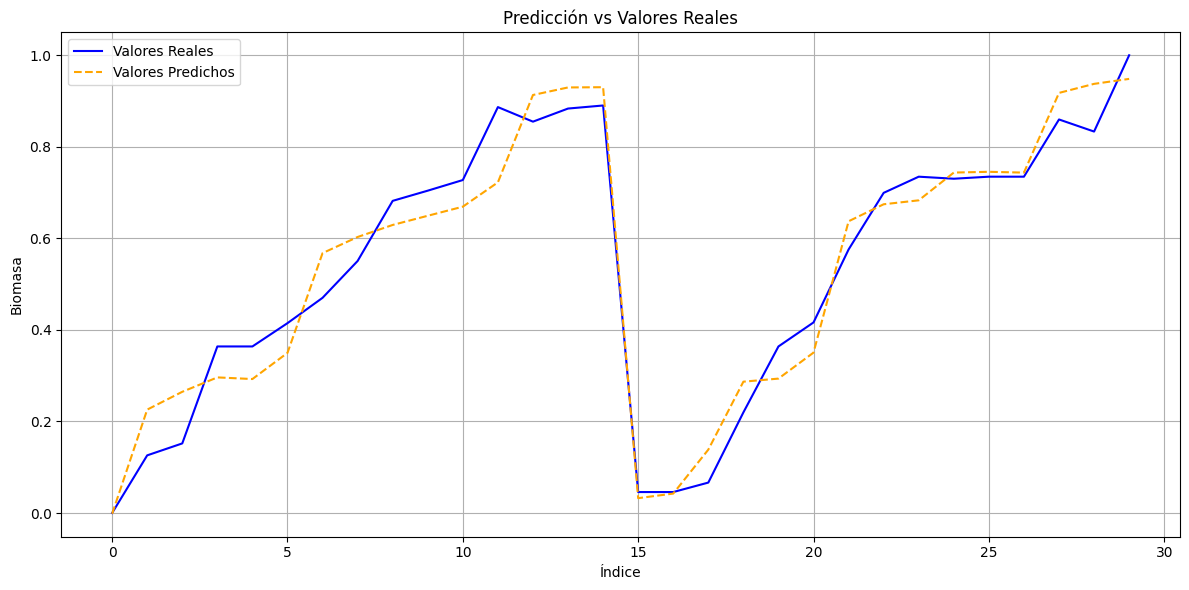

In [31]:
# 1. Serie Temporal de Predicción vs Valores Reales
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Valores Reales', color='blue')
plt.plot(y_pred, label='Valores Predichos', color='orange', linestyle='--')
plt.title('Predicción vs Valores Reales')
plt.xlabel('Índice')
plt.ylabel('Biomasa')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

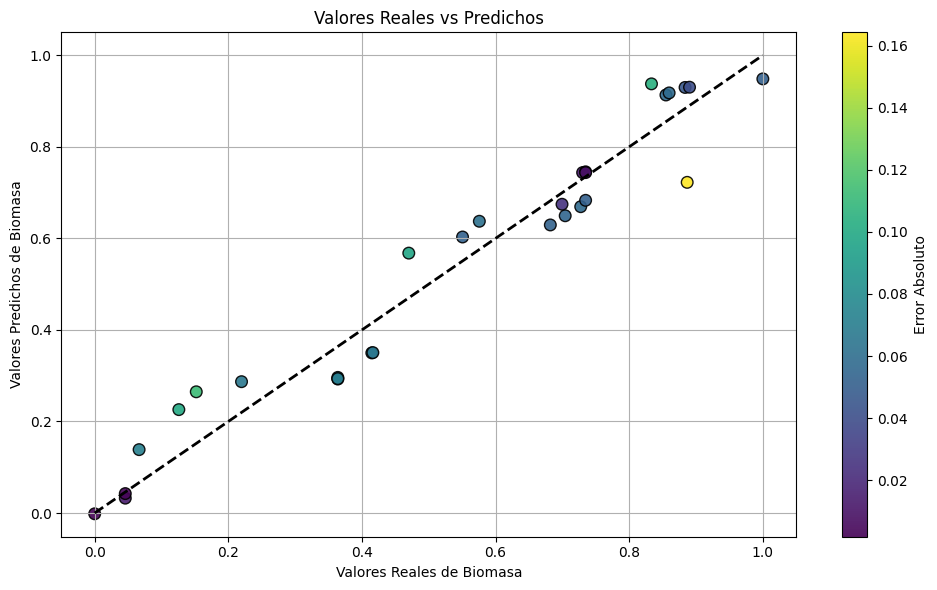

In [32]:
# 2. Gráfico de Dispersión de Predicción vs Real
plt.figure(figsize=(10, 6))
scatter = plt.scatter(y_val, y_pred, c=np.abs(y_val - y_pred), cmap='viridis', s=70, alpha=0.9, edgecolor='black')
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)
plt.title('Valores Reales vs Predichos')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Valores Predichos de Biomasa')
cbar = plt.colorbar(scatter)
cbar.set_label('Error Absoluto')
plt.grid(True)
plt.tight_layout()
plt.show()

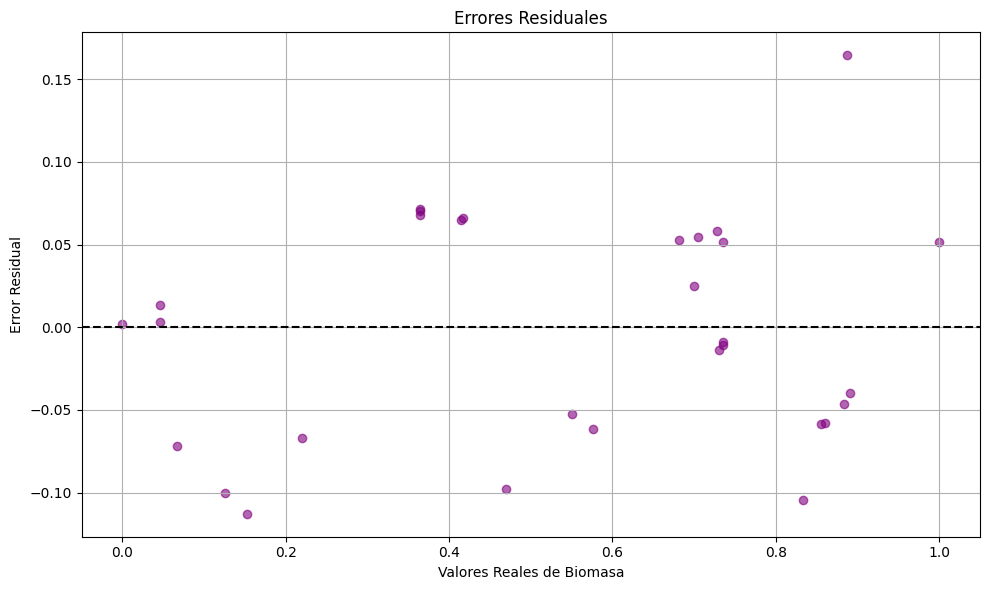

In [33]:
 # 3. Gráfico de Error Residual
residuals = y_val - y_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_val, residuals, alpha=0.6, color="purple")
plt.axhline(0, linestyle='--', color='black')
plt.title('Errores Residuales')
plt.xlabel('Valores Reales de Biomasa')
plt.ylabel('Error Residual')
plt.grid(True)
plt.tight_layout()
plt.show()

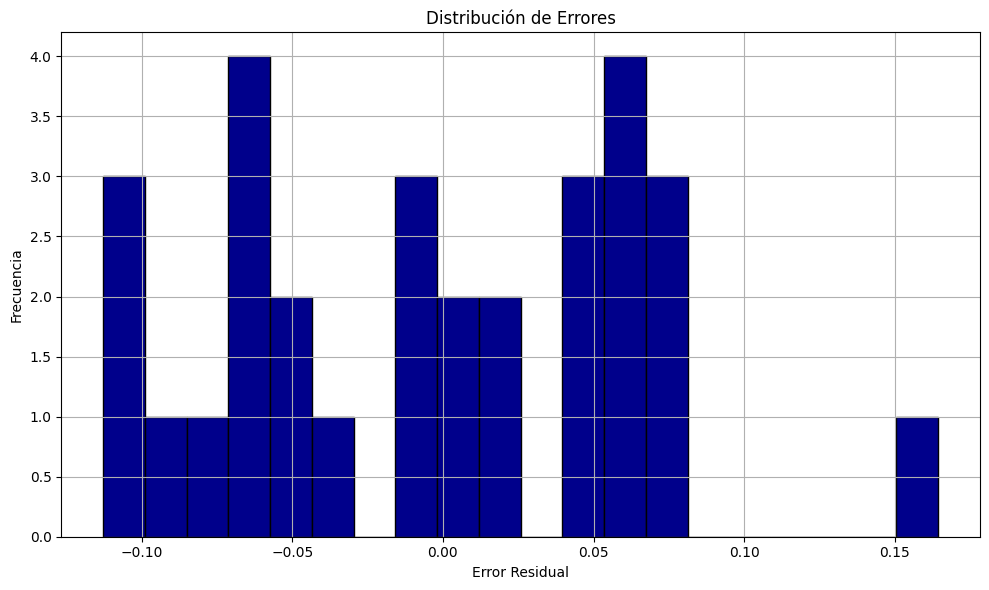

In [34]:
    # 4. Histograma de Errores
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color="darkblue", edgecolor='black')
plt.title('Distribución de Errores')
plt.xlabel('Error Residual')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.tight_layout()
plt.show()

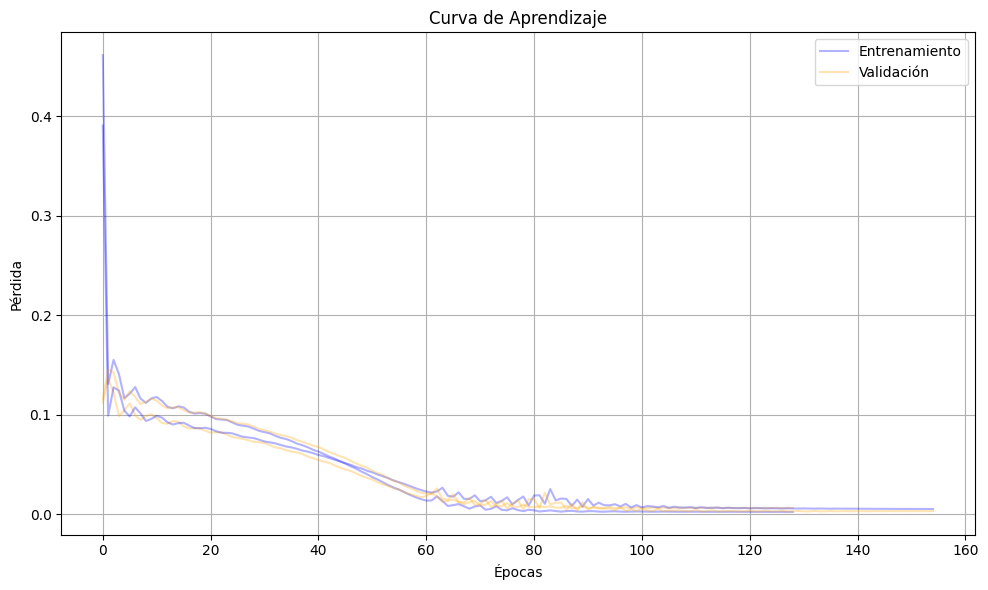

In [35]:
# 5. Curva de Aprendizaje
plt.figure(figsize=(10, 6))
for fold_history in history:
    # Graficar las pérdidas de entrenamiento y validación
    plt.plot(fold_history['loss'], color='blue', alpha=0.3, label='Entrenamiento')
    plt.plot(fold_history['val_loss'], color='orange', alpha=0.3, label='Validación')

# Ajustes adicionales al gráfico
plt.title('Curva de Aprendizaje')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend(['Entrenamiento', 'Validación'])  # Añadir etiquetas únicas
plt.grid()
plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


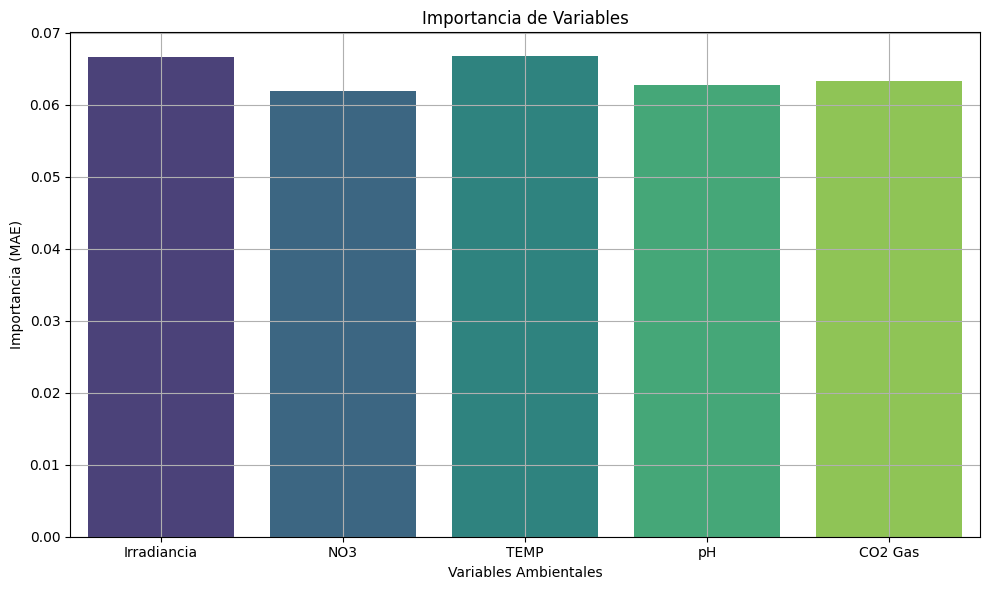

In [36]:
# 6. Gráfico de Importancia de Variables (Análisis de Sensibilidad)
importances = []

# Asegurar que las dimensiones coincidan (ajustar X_val para que tenga 15 muestras)
X = data[input_features].values  # Usar las columnas de características de entrada
X_val = data[input_features].iloc[:len(result['img_val'])].values  # Ajustar tamaño de X_val al de img_val

# Calcular importancia de cada característica perturbándola
for feature_idx in range(X.shape[1]):
    X_temp = X_val.copy()  # Copia del conjunto de validación
    X_temp[:, feature_idx] = np.mean(X[:, feature_idx])  # Perturbar la variable
    perturbed_pred = result['model'].predict([result['img_val'], X_temp]).flatten()  # Predicción con perturbación
    importance = mean_absolute_error(result['y_val'][:len(result['img_val'])], perturbed_pred)  # Calcular impacto en el error
    importances.append(importance)  # Almacenar la importancia

# Gráfico de Importancia de Características
plt.figure(figsize=(10, 6))
sns.barplot(x=input_features, y=importances, palette="viridis")
plt.title('Importancia de Variables')
plt.xlabel('Variables Ambientales')
plt.ylabel('Importancia (MAE)')
plt.grid(True)
plt.tight_layout()
plt.show()

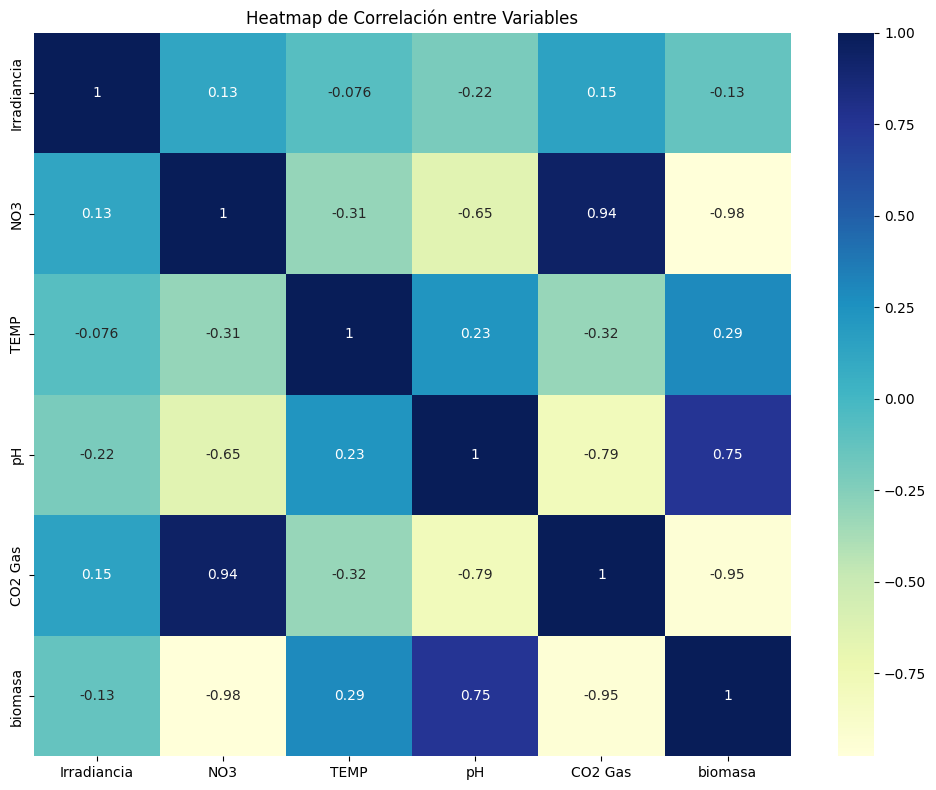

In [37]:
# 7. Heatmap de Correlación entre Variables
plt.figure(figsize=(10, 8))
sns.heatmap(data[input_features + [output_feature]].corr(), annot=True, cmap="YlGnBu")
plt.title("Heatmap de Correlación entre Variables")
plt.tight_layout()
